PROC CORR
=============
https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_reg_sect017.htm  
correlation of -.4 is as strong as one of +.4  
BEST: limit the top correlation variable  
WITH: instead of covariance matrix (corr with itself), it check the correlation with other variable  
NOSIMPLE: suppress descriptive statistics  

### Partial Correlations
strenght of 2 varr when effect of other variables has been removed.  
to remove the effect of one or more variable from correlation , use PARTIAL rmVarList


In [7]:
DATA CORR_EG;
  INPUT GENDER $ HEIGHT WEIGHT AGE;
  HEIGHT2=HEIGHT**2;
DATALINES;
M 68 155 23
F 61  99 20
F 63 115 21
M 70 205 45
M 68 170 .
F 65 125 30
M 72 220 48
;

PROC CORR DATA=CORR_EG;
  VAR HEIGHT WEIGHT;
  PARTIAL AGE;
RUN;
  

PROC REG
==================
*indVar  

MODEL dep = ind /options  
STORE forScore: save the model for scoring  
PLOT PREDICTED. or RESIDUAL.: to plot predict value or error  
OVERLAY: plot more than one graph on a single set of axes  
OUTEST: dataset with BY variable and slopes  
ID: var need to save
BY: each group has a model

MODEL dep = indep /SELECTION=FORWARD SLENTRY=p-value(default=.5) SLSTAY=p-value  
MODEL dep = indep /SELECTION=STEPWISE: use p-value=0.15  
MODEL dep = indep /SELECTION=MAXR: use highest r-square  
MODEL dep = indep /SELECTION=RSQUARE: list r-square for every one, two, three, ...combinations of variable in the indpendent varaible list

### METRIC
Coefficient of Variation (Coeff Var): RMSE / mean, useful in income data because mean and std. dev. are related
CookD: determine how strongly a particular datapoint affect overall regression, |D| >= 2 might require take out the outliers and retrain    
Significant diff in predictor: intercept is not significantly diff is OK, but not for predictor, they must be significant diff than zero

### Quadratic
HEIGHT2: add quadratic term in DATA STEP, then put into MODEL stmt

### Create dummy variable
```
DUMMY_G=INPUT(TRANSLATE(GENDER,'01','MF'),1.);
```



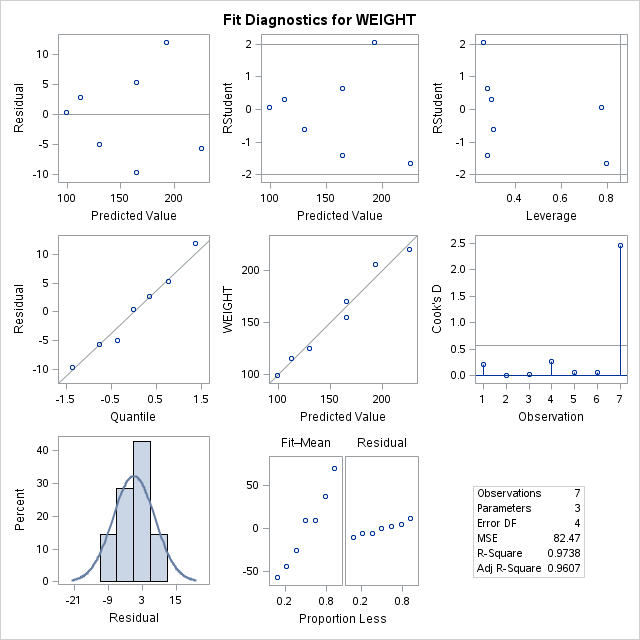
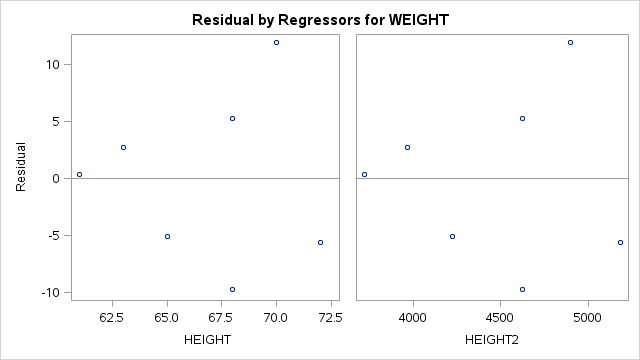

In [8]:
PROC REG DATA=CORR_EG OUTEST=SLOPES;
  MODEL WEIGHT = HEIGHT HEIGHT2;
  PLOT PREDICTED. *HEIGHT='P' 
     U95M. *HEIGHT='-'
     L95M. *HEIGHT='-'
     WEIGHT*HEIGHT='*' / OVERLAY;
  PLOT RESIDUAL. *HEIGHT='o';
RUN;

In [9]:
proc print data=SLOPES;
RUN;

Obs,_MODEL_,_TYPE_,_DEPVAR_,_RMSE_,Intercept,HEIGHT,HEIGHT2,WEIGHT
1,MODEL1,PARMS,WEIGHT,9.08131,1707.61,-58.5068,0.52672,-1



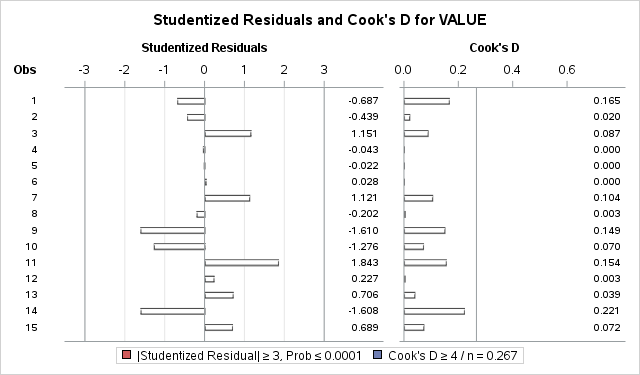
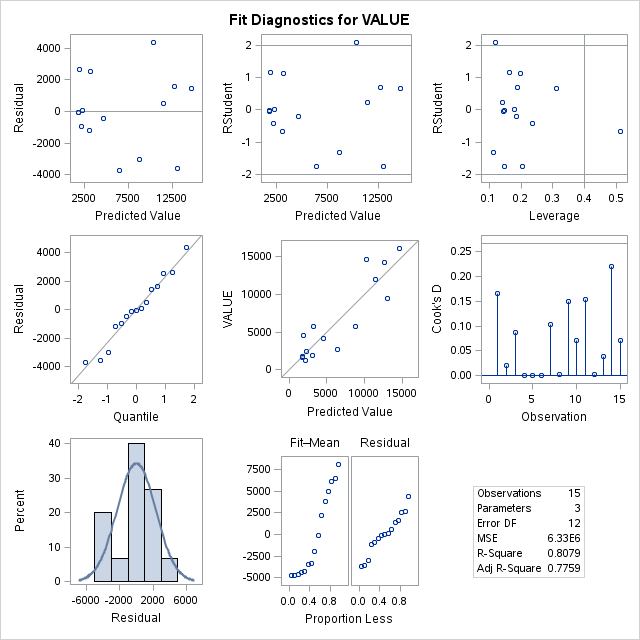
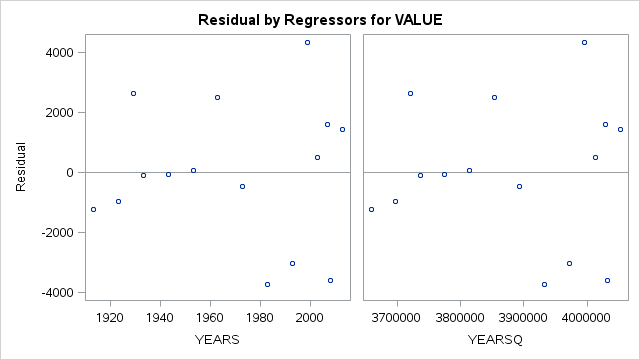
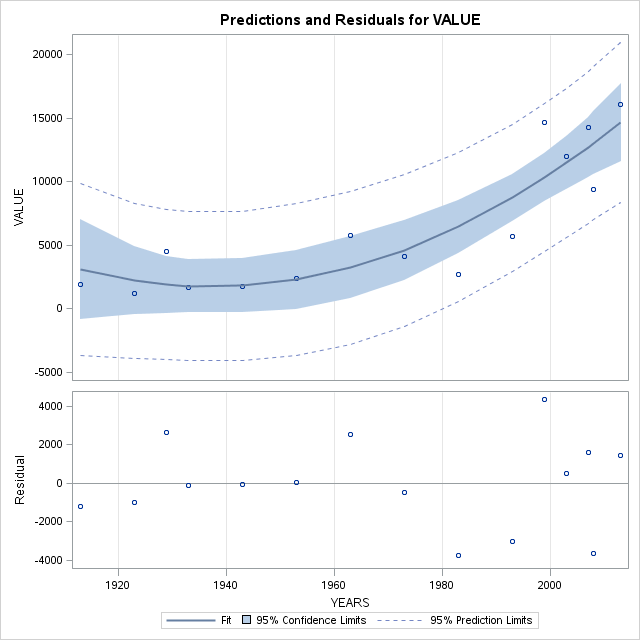

In [1]:
DATA DJIA;
INPUT YEARS VALUE;
YEARSQ=YEARS**2;
YEARSCUB=YEARS**3;
DATALINES;
1913 1886
1923 1252
1929 4556
1933 1694
1943 1770
1953 2367
1963 5761
1973 4161
1983 2715
1993 5727
1999 14690
2003 12018
2007 14315
2008 9421
2013 16123
;
PROC REG DATA=DJIA PLOTS=PREDICTIONS(X=YEARS);
MODEL VALUE= YEARS YEARSQ /P R; *linear model value(independent variable)=year(dependent) / P for predicted value, R for residuals; 
RUN;
/*
* parameter estimates
* intecept = -242272 tells me that in the year zero the value of djia was 242272
* LINEAR REGRESSION ISNT THE BEST FOR THIS TYPE OF DATA
* 
* (*) POLYNOMIAL REGRESSION
* 		PROC REG
*		 MODEL Y(DEPENDENT)=x xsq xcu;
*			Y= 8491118-8763.775(YEAR)+2.26176((YEAR)^2)
*  			We need to make sure that they are:
*				(1) INDEPENDET
*				(2)	NORMAL
*				(3) CONSTANT VARIABLE
*	To find independence we look at the first graph(we dont want any pattern)
*	fading out in the data look at graph (1)(2)
*	(3) LEVERAGE one point is really off (2008 year)
*	(0,2000)
*	(100,17000)
*/



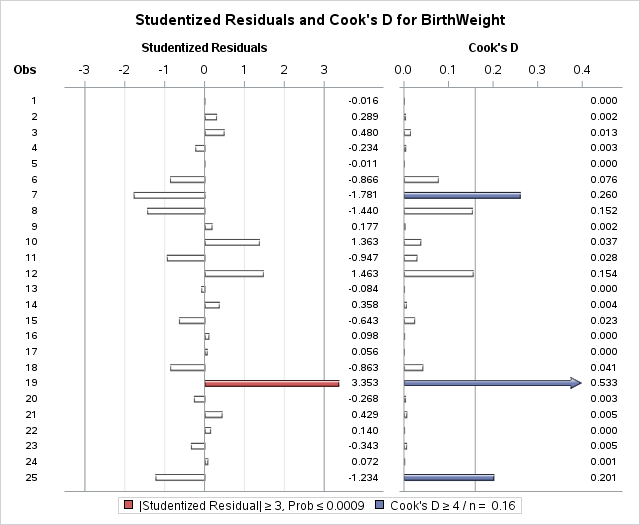
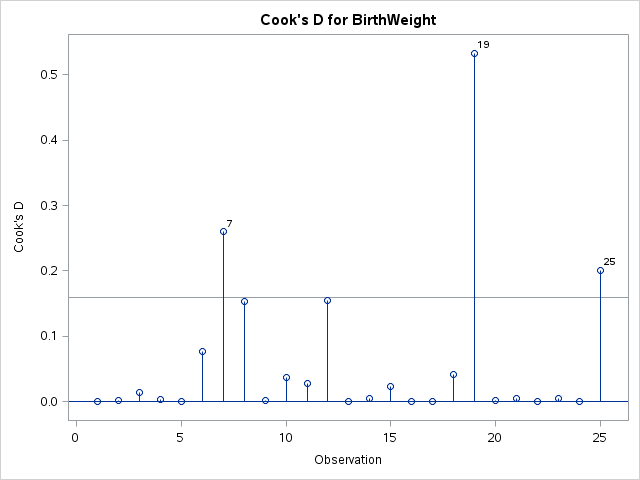
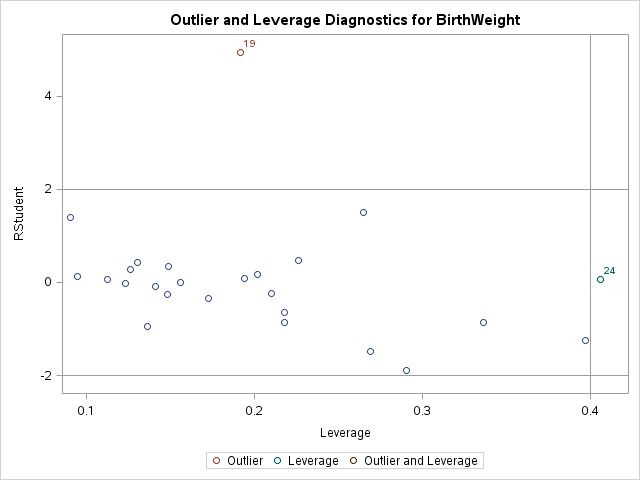
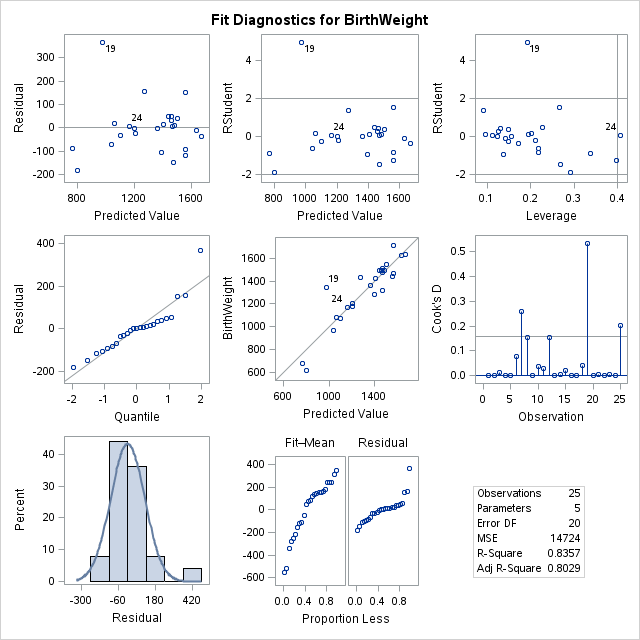
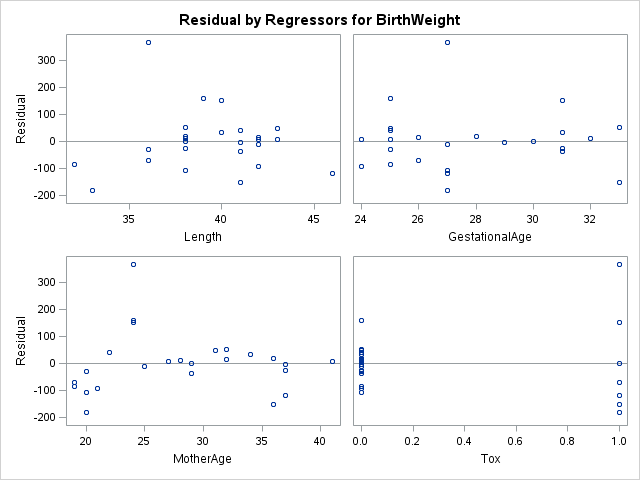

In [10]:
/*
 * ----ASSIGMENT_5---------
 * Author: Jose L Rodriguez
 * Assigment: 8
 * Problem: 1
 * Date: December 5th, 2014
 * SAS303 - FALL 2014
 * SAS 9.4 TS Level 1M1
 * W32_7PRO platform
 */
PROC IMPORT OUT=MULTI_REG 
        DATAFILE="/folders/myfolders/SAS-Programming/HW_8/MultiRegressionBirthWeight.xlsx" 
        DBMS="xlsx" REPLACE;
    SHEET="Sheet1";
    GETNAMES=YES;
RUN;

DATA Birth_Weight;
    SET MULTI_REG;
    
	If _n_ = 16 then delete;
    
	IF Toxemia="Y" then
        Tox=1;
    ELSE
        Tox=0;
/*
PROC REG DATA=Birth_Weight  plots(label)=(RStudentByLeverage CooksD);
    MODEL BirthWeight=HeadCircumference Length GestationalAge MotherAge Tox/ VIF collin r 
	selection = stepwise;
    output cookd=cooksd;
    RUN;
quit;
*/

PROC REG DATA=Birth_Weight  plots(label)=(RStudentByLeverage CooksD);
    MODEL BirthWeight=HeadCircumference Length GestationalAge MotherAge Tox/ VIF collin r 
	selection = cp best=3;
    output cookd=cooksd;
    RUN;
quit;

/*
PROC G3GRID DATA=Birth_Weight  OUT=WEIGHT_3D;
GRID Length*GestationalAge=BirthWeight/
	AXIS1=32 TO 46 BY 1
	AXIS2=24 TO 33 BY 1;
RUN;

PROC G3D DATA=WEIGHT_3D;
PLOT Length*GestationalAge=BirthWeight/ROTATE=45 TILT=80;
RUN;
*/

/*
1. weight = head_c head_l g_age, m_age toxemia

a) 	What is the equation that predicts the weight?

	weight = - 3047.0619 - 0.37405(h) - 24.20375(m) - 141.40841(t) + 89.92833(l) + 56.15158(g) 	

	What does each of the partial slopes indicate?
	The partial slopes B1,B2,B3,B4 and B5 represents the expected change in the response of weight
	for a unit increase of each partial slope given that the rest keep constant. 

b) 	Does there appear to be any issue with multi-collinearity?  Explain.
	Yes, there is an issue with multi-collinearity on (5) and (6) both have small values and 
	condition index over 30.
	
c) 	There is an outlier in the data due to a miss-recorded piece of data. How can you tell?
   	What observation number is it?
	We can tell that it was miss-recorded if we compare the value with other values of the same
	variable also a birth weight so large is not possible, the observation number was at subject 16.

B)  Remove the outlier from the data. Run a stepwise multiple regression analysis on the data.
	Include the same information as in part a)

a)  Which variables did the stepwise method toss out?  Why did the model stop at step  it did
	and not toss any more variables out of the model?  State the statistical number that helped
	SAS make this conclusion.
	
	The stepwise method toss out head Circumference and Birth Weight. Because the model best model
	is bound to the condition numbers 1.9499, 24.382  and all the variables left in the model 
	are significant at the 0.1500 level, while no other variable met the 0.1500 significance 
	level, therefore they were not include in the model. Sas uses Mallow Cp statistic to determine
	when to add more variables, as C(p) approches 1 + (number of variables) then SAS stops.
	 
b)	Analyze your Cooks D output. What observation number seems to be contributing to the
	error of the model? Should we remove this data point from our analysis, why or why not?
	You might look at that data point.
	
	After removing the observation 16 the Cook's D output shows that observation 20 is contributing to
	the error of the model. We should not take out anyother observation as they are part of the sample
	in this case if we take out observation 20 as well there is going to be another observation that
	contributres to the error of the model.

c) 	Analyze the fit diagnostic output for the independence, normality and constant variance.
	Does the model seem to violate any of these or not? Explain.
	
	Diagnostic analysis: 
	Independence: It doesnt seem to be a big problem with in independence, maybe some values are 
	values concentrate in the middle but they are pretty much evenly distributed.
	Normality: From the prencent VS Raw Residual it looks like the residuals are somewhat normal.
	Constant Variance:From the residual VS Predicted Plot, the graph gets in a slightly upside down
	U shape from left to right. For bigger Y values (x approaching 0), the residuals are smaller.
	
	Overall the model doesnt seem to violate any of these diagnostics.

C)  Run a cp multiple regression analysis on the amended data (outlier from first part thrown out)
	(selection = cp) and include best =3 as another option. This will a list of the independent
	variables and the adj-r squared values for the top three models based on the Mallow C(p) statistic.

a) 	What are the top three models and the adj r-square value for each model?

	Number Model 	R-Square 	Variables in Model
		4  			0.8357 		Length GestationalAge MotherAge Tox
		5 			0.8358 		HeadCircumference Length GestationalAge MotherAge Tox
		3 			0.7843 		Length GestationalAge MotherAge

b)  Output your top model to a new data set and create a perspective plot of the model
	with birth weight plotted against length and gestational age.Choose a rotation and 
	tilt that give the plot a nice perspective and analyze the plot for max and min 
	values and trends. Logically, the longer baby and the baby with an older gestational 
	age should have the highest birth weight. 
	There is a parabolic shape for babies with a younger gestational age.  Why might that be?
	
	Because there is a minimun/average birth weight that dependents of the gestation age 
	for a new born to be healthy, and we can see from the graph how as the gestation age increase
	the new born lenght and weight increase as well.
	
*/

PROC PLM for scoring linear model
--------------

proc score with new data using the model
===========================================

PROC LOGISTIC
=======================
Forces prediction equation predict values between 0 and 1, natural log of odds for subject being in one category or another.  
DESCENDING: resulting equation predicts the log odds for the LOWER value of the dependent variable. So if we follow tradition and code Yes as a 1 and No as a 0, the equation would predict the log odds of NOT having an accident. DESCENDING will reverse cause the program to predict the log odds of having an accident given a certain set of predictor or explanatory values

EVENT specifies the event category for the binary response model.  
REF specifies the class level to be used as the reference level for reference coding  
PLOTS(ONLY) specifies which plots to display.  
EFFECT displays and enhances the effect plots of the model.  
ODDSRATIO displays and enhances the odds ratio plots for the model when the CLODDS=option or the ODDSRATIO statement is also specified.  
ROC displays the ROC curve.  
ILINK computes the estimate on the original data scale.  
P requests the predicted probabilities (based on the model) to be included in the output data table.  

MODEL dep = indep / CTABLE = (0 to 1 by .1): classification table for all probabilities form 0 to 1 by .1  
MODEL dep = indep / LACKFIT: Hosmer and Lemeshow Goodness-of-Fit test  
MODEL dep = indep / RISKLIMITS: odd ratio for each varaible ${Odd(event|var) \over Odd(event|!var)}$ with 95ci  
MODEL dep = indep / SELECTION=FORWARD: for variable selection  
MODEL dep = indep / OUTROC=ROC: ROC dataset for sgplot  

$$Odds= {P \over 1-P}$$
$$P = {Odds \over 1+ Odds}$$
log(odds) = linear equation  
odds = exp(linear equation)  
Sub odds into $P = {Odds \over 1+ Odds}$




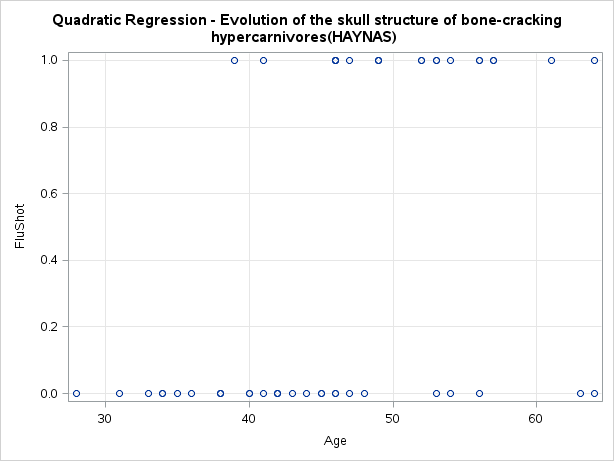
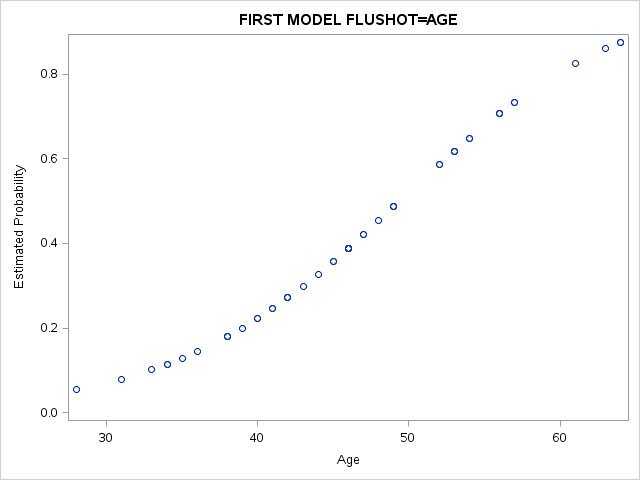
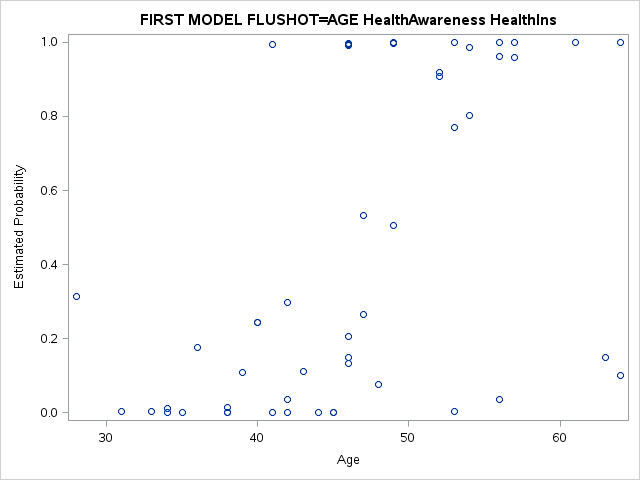

In [11]:

/*
 * ----ASSIGMENT_5---------
 * Author: Jose L Rodriguez
 * Assigment: 8
 * Problem: 2
 * Date: December 5th, 2014
 * SAS303 - FALL 2014
 * SAS 9.4 TS Level 1M1
 * W32_7PRO platform
 */
PROC IMPORT OUT=Flushot
            DATAFILE="/folders/myfolders/SAS-Programming/HW_8/FluShot.xlsx"
            DBMS="xlsx" REPLACE;
        SHEET="Sheet1";
        GETNAMES=YES;
RUN;

DATA Health;
        SET Flushot;


ods graphics / reset width=6.4in height=4.8in imagemap;
proc sgplot data=WORK.HEALTH noautolegend;

        scatter x=Age y=FluShot / transparency=0.00 name='Scatter';
        xaxis grid;
        yaxis grid; 
run;
ods graphics off;

PROC LOGISTIC DESCENDING;
MODEL FluShot=age/ RISKLIMITS pprob=1 outroc=ROCData ;
OUTPUT OUT=LOG_FLU_OUT PREDICTED=Pre_FluShot;
title "FIRST MODEL FLUSHOT=AGE";
RUN;

PROC SORT;
BY AGE;
/*
Proc Gplot  data = LOG_FLU_OUT;
Plot Pre_FluShot*age;
Run;
*/
PROC SGPLOT DATA=LOG_FLU_OUT;
SCATTER X=age Y=Pre_FluShot;
run;

PROC LOGISTIC DESCENDING;
MODEL FluShot=age HealthAwareness HealthIns/ RISKLIMITS lackfit pprob=1 outroc=ROCData ;
OUTPUT OUT=fulllogfluout PREDICTED=full_flu;
title "FIRST MODEL FLUSHOT=AGE HealthAwareness HealthIns";
RUN;
quit;

PROC SORT;
BY AGE;
/*
Proc Gplot data = fulllogfluout;
Plot full_flu*age;
Run;
*/
PROC SGPLOT DATA=fulllogfluout;
SCATTER X=age Y=full_flu;
run;

PROC G3GRID DATA=fulllogfluout  OUT=flue_3D;
GRID age*HealthIns=FluShot/
    AXIS1=25 TO 75 BY 1
    AXIS2=0 TO 2 BY 0.25;
RUN;

PROC G3D DATA=flue_3D;
PLOT age*HealthIns=FluShot/ROTATE=75 TILT=75;
RUN;


PROC LOGISTIC DESCENDING;
MODEL FluShot=age HealthAwareness HealthIns/ selection=forward ;
OUTPUT OUT=fulllogfluout PREDICTED=full_flu;
title "FIRST MODEL FLUSHOT = AGE HealthAwareness HealthIns FORWARD";
RUN;
quit;   

/*
	2)  Flu Shot:  The file FluShot.xlsx contains data on 50 subjects; age, healthawareness, 
		healthins, flushot.  The variable HealthAwareness is a score between 0 and 100 for a subject’s 
		awareness of health issues. HealthIns corresponds to the subject’s health coverage;  
		0 = no health insurance, 1 = minimal health insurance,  2 = more than minimal insurance.  
		
		The variable flu shot is a binary variable which indicates if the subject received a 
		flu shot (1) or did not (0) for the upcoming flu season.

	a)  Create a scatter plot flu shot versus age and analyze the plot.  Does there appear to 
		be any issue with separation for a logistic regression analysis? Explain. Include the 
		scatterplot.
		
		For a logistic regression to occur the dependent variable nnes to have two levels (binary)
		in this case we case see in the graph that the variable has two levels also the model range
		is between 0 and 1 and fits logaritmic transformation.
	
	b) Write the code to perform a logistic regression on the flu shots with age as the regressor 
	   (independent variable) and a probability model of flushot = 1. Include the risk limits tables 
		and the Receiver Operating Characteristic Curve output.  Output the predicted values to 
		the dataset logfluout. Write the code to produce the probability plot.
	
	1) Is the model statistically significant at the 95% CL.?  Include the Global Output table.
		Yes the model is significant at 95% confidence level according to the Global output table,
		the three test as less than 0.05.

	2)  What is the equation for the odds of the getting a flu shot based on age?  
	
		y = -6.5910 + 0.1334(age)
	
		What is the equation to calculate the probability a person gets a flu shot base on their age? 
		
		    [e^{-6.5910 + 0.1334(age)}]
	  p = --------------------------------
		   	1 + e^{-6.5910 + 0.1334(age)}
		
	 Fill in the following chart
  __________ _______________________________________ _______________________________________________
 |____Age___|_____Odds a person got a flu shot______|______Probability a person got a flu shot______|
 |			|										|												|
 |	 23		|			 -3.5						|					0.0286704					|
 |	 37		|			 -1.65						|					0.160407					|
 |	 60		|		      1.4						|					0.804239					|
 |__________|_______________________________________|_______________________________________________|

	3) Include the odds ratio estimate and include an explanation of what this means.
	 _____________________________________________________
	|													  |
	| Odds Ratio Estimates and Wald Confidence Intervals  |
	|_____________________________________________________|
	|		  |		   |			|					  |
	| Effect  |	Unit   |Estimate 	|95% Confidence Limits|
	|		  |		   |			|			|		  |
	| Age 	  |	1.0000 | 1.143 		|	1.046 	|	1.24  |
	|_________|________|____________|___________|_________|
	
	Since we are looking at age a numerical value, the odds ratio gives us the odds of getting the flue shot
	increase as the age increase. 
	
	4) Include the ROC curve.
	
c)  Adapt your code to perform a logistic regression on the flu shots including all 
	the regressors (age, healthawareness, healthins) and a probability model of 
	flushot = 1.  
	
	Include the lackfit table and Receiver Operating Characteristic Curve output.  
	Output the predicted values to the dataset fulllogfluout. Write the code to produce a 3-D 
	probability perspective (surface) plot using Age on one axis with limits from 25 to 75 by 1 
	and HealthIns on the other axis from 0 to 2 by 0.25 and the ROC curve.  

	Paste the code here.

	Include the following output and analyze it
	1)  Global Output table.  Is the model statistically significant at the 95% CL.?
		 At 95% significance level the first two test have a very small chi-square,
		 but the last test Wald if very close to 0.05 its still below the rejection level, but it isnt
		 as strong as the other two test.
	
	2)  What is the null and alternative hypothesis for this test?  Interpret your p-value for the 
		chi-square test.
		
		Ho: The data fits the expected values.
		Ha: The data doesnt fit the expected values.
		
		The Hosmer and Lemeshow Goodness-of-Fit Test Chi-Square is 0.9191 therefore we fail to reject the 
		Null the data is a good fit for the model.
		
	3)  ROC curve.   Compare it to the ROC curve in part b.  Which model demonstrates higher 
		accuracy and why?
		
		The model from part b is not as accurate in comparison to the last model as this values have a 
		greater deviation and arent as consistance as the second model.
		
	4)  3-D graph. Interpret it as best as you can. You may need to rotate.  
		Be sure to use the edges as a guide to your analysis.
		
		In the 3D model we can see how as people get better health insurance and get older the flu shots 
		increase, althought the edges are important because it seems like at the extreme values the flu shots
		is always low or zero.

    d)  Adapt your code to perform a logistic regression on the flu shots including all the regressors
        (age, healthawareness, healthins) using the forward method. Paste the code here.

        PROC LOGISTIC DESCENDING;
        MODEL FluShot=age HealthAwareness HealthIns/ selection=forward ;
        OUTPUT OUT=fulllogfluout PREDICTED=full_flu;
        RUN;
        quit;
        
        1) What is the most important predictor of getting a flu shot?
        	
        	HealthIns
        
        2) What is the second most important predictor of getting a flu shot?
        
        	Age
*/

Use PROC GENMOD to specify the distribution or use the LINK= function to create a generalized linear model.
----------------------------------------------------------------
In R:
```
mylm=glm(Satellites~Weight,family=poisson)
anova(mylm);
summary(mylm);
```

DIST specifies the distribution of the response variable.  
LINK specifies the desired link function to be used for analysis.  

Poisson regression models assume that the variance is equal to the mean. However, count data often exhibit variability that exceeds the mean. Overdispersion leads to underestimating the standard errors of the parameter estimates and overestimates the results of the tests statistics. To correct overdispersion, use the negative binomial distribution in the PROC GENMOD MODEL statement. This distribution also models count data but allows the variance to exceed the mean. Use a STORE statement to save the model for prediction.

proc nlin
=============


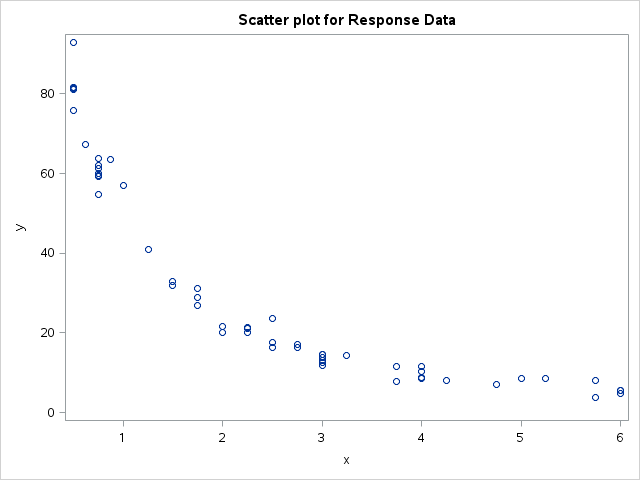
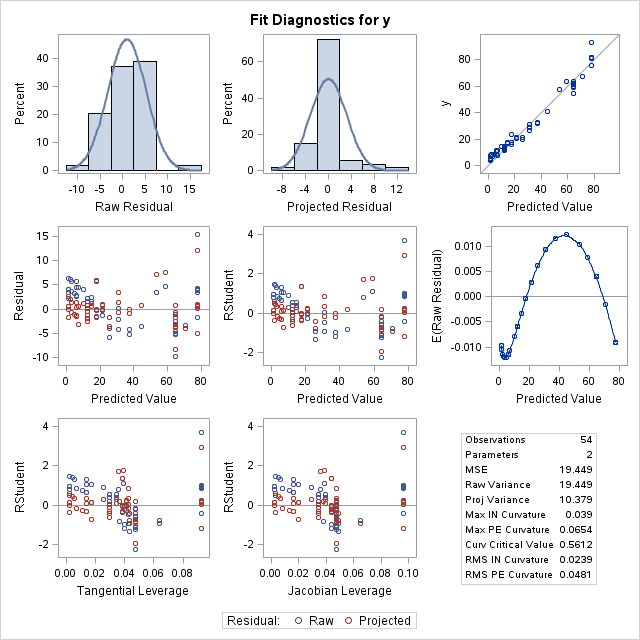
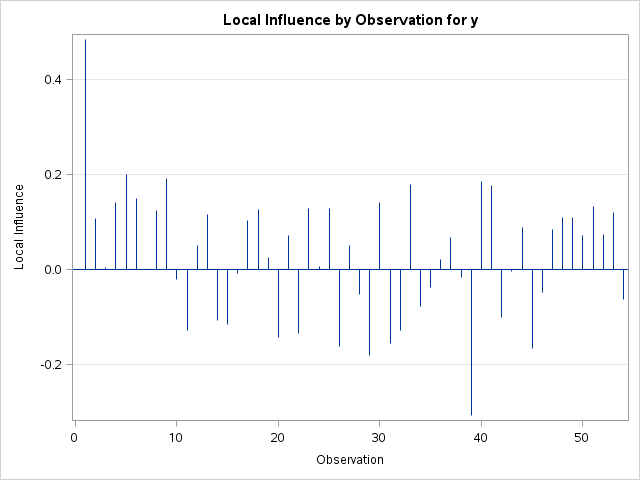
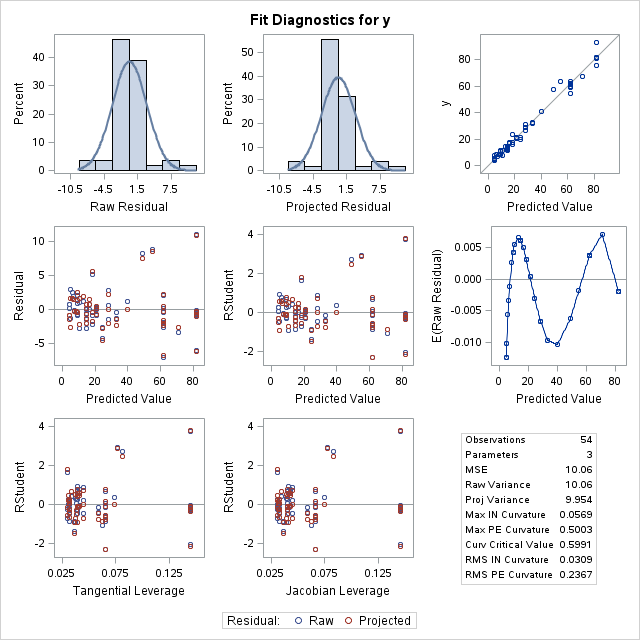
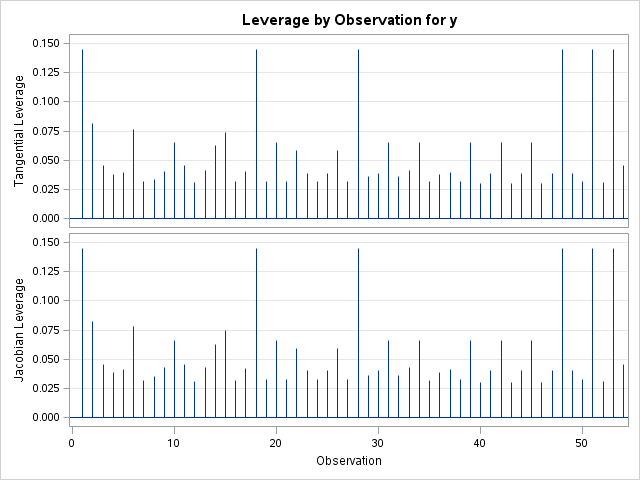
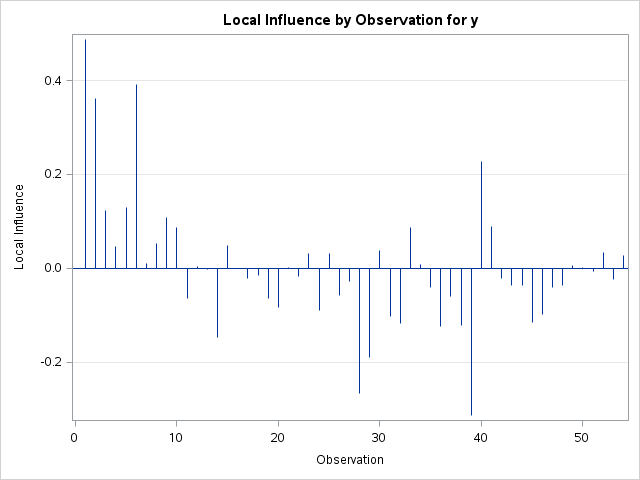

In [12]:
/*
 * ----ASSIGMENT_5---------
 * Author: Jose L Rodriguez
 * Assigment: 6
 * Problem: 1
 * Date: October 26th, 2014
 * SAS303 - FALL 2014
 * SAS 9.4 TS Level 1M1 
 * W32_7PRO platform
 */
PROC IMPORT OUT=RESPONSE_DATA DATAFILE="/folders/myfolders/SAS-Programming/HW_6/Response.xlsx"
			DBMS=xlsx REPLACE;
			SHEET="Sheet1";
			GETNAMES=YES;
RUN;

DATA NonLin_Response;
SET WORK.RESPONSE_DATA;
ODS GRAPHICS ON;

PROC SGPLOT DATA=NonLin_Response;
TITLE "Scatter plot for Response Data";
SCATTER X=X Y=Y;
RUN;

PROC NLIN PLOTS=DIAGNOSTICS(STATS=ALL);
PARAMETERS 	a=80
			b=-0.5;
MODEL y=a*exp(b*x);
TITLE "NonLinear Regression Model [y = ae^(bx)] for Response Data";
RUN;

PROC NLIN PLOTS=DIAGNOSTICS(STATS=ALL);
PARAMETERS 	a=0.1
			b=0.1
			c=0.1;
MODEL y = exp(a*x)/(b+c*x);
TITLE "NonLinear Regression Model [y = e^(ax)/(b + cx)] for Response Data";
RUN;

ODS GRAPHICS OFF;
QUIT;

/* 		Residual sum of squares (RSS) is the sum of squares of residuals. 
		(SSR) or the sum of squared errors of prediction (SSE). It is a measure of the discrepancy between the data 
		and an estimation model. A small RSS indicates a tight fit of the model to the data.

 *	c) 	What is the sum of the squares when convergence is met? 
  *		Analyze the residual assumptions. Explain how you decide on the parameters for a and b.
 *		The parameters were determine by looking at the local minimals and the scatter plot graph.
 *		When we analyze residuals we are looking for:
 * 			Sum of Squares = 89484.3
 *		(1) Independence (NOT_pattern)
 *			-> 	From the residual plot it doesnt look like there is a pattern but the projected residual could get
 *				closer to the real value to have a better model.
 *		(2)	Normality of the error distribution.
 *			-> From the graph we can see that the model keeps normality and its slightly negative skewed.
 *		(3)	Constant Variable of erros (Homoscedastic)
 *			-> From graph number three we can infer that the model is Homoscedatic.
 *	
 *	d) 	Uing Proc Nlin create a nonlinear regression of the form y = e^(ax)/(b + cx). Analyze the residual assumptions.
 *		What is the sum of the squares when convergence is met and is it better or worse than the model in part c?
 *			Sums of Squares= 89982.5 For this model the residuals he residuals appear to behave randomly, 
 *			suggesting that the model fits the data well. Although thw SSE is larger than the fisrt model therefore 
 *			the first model is better.
 *		
 *
 *
 */



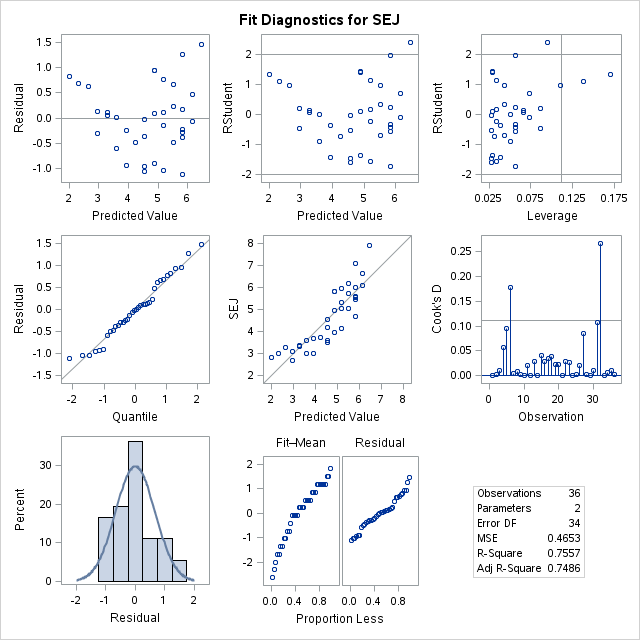
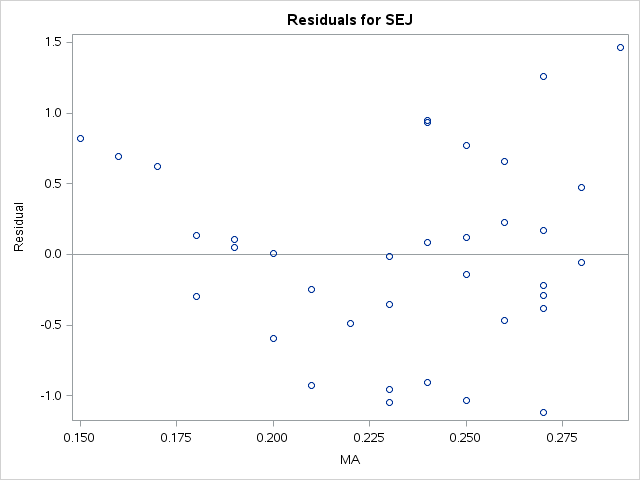
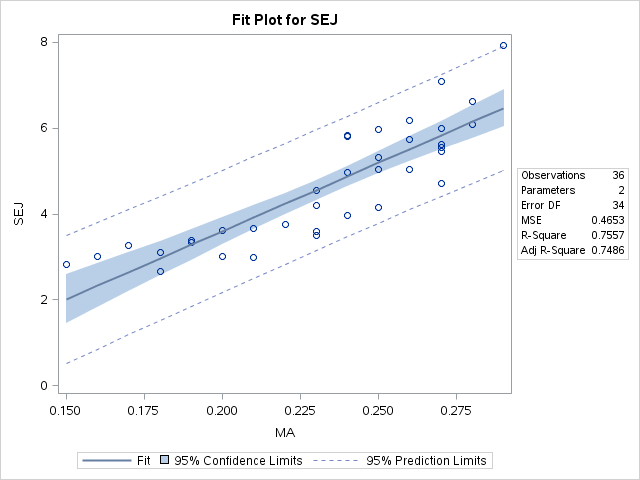

In [13]:
/*
 * ----ASSIGMENT_5---------
 * Author: Jose L Rodriguez
 * Assigment: 5
 * Problem: 3_a_b
 * Date: October 17th, 2014
 * SAS303 - FALL 2014
 * SAS 9.4 TS Level 1M1 
 * W32_7PRO platform
 */

PROC IMPORT OUT=HAYNAS DATAFILE="/folders/myfolders/SAS-Programming/HW_5/BCHD.xls"
			DBMS=XLS REPLACE;
			SHEET="SHEET1";
			GETNAMES=YES;
RUN;

DATA HAYNAS_DATA_LINEAR;
SET WORK.HAYNAS;
PROC REG DATA=HAYNAS_DATA_LINEAR;
MODEL SEJ=MA;
PLOT SEJ*MA/PRED;
TITLE "Linear Regression - Evolution of the skull structure of bone-cracking hypercarnivores(HAYNAS)";
RUN;
QUIT;

/*
 *	3.  Evolution of the skull structure of bone-cracking hypercarnivores(HAYNAS)
 *				   RATIO OF SKULL
 *			(DL)	DEPTH/LENGTH
 *			(WL)	WIDTH/LENGTH
 *
 *			mechanical advantage (MA) – how hard the bite is relative to the energy exerted to create the bite, 
 *			strain energy (SEJ)- energy of deforming the skull/mandible as it crushes its prey (in jules).   
 *
 *			OPTIMIZED SHAPE (PROPERTIES OF THE STRUCTURE)
 *				(1)	MECHANICAL ADVANTAGES 	(MA)
 *				(2)	STRAIN ENERGY in JULES	(SEJ)
 *
 *	a)	Perform a linear regression of SEJ vs, MA. Write out the model (SEJ  = m*MA + b)
 *			SEJ= 31.81161*MA -2.76054 
 *
 *	b) 	Analyze the r-square value and the output from the 9 panel data. Why is a linear regression model not the best model?  
 *		Include the parameters output and 9 panel residual analysis plot.
 *
 *		R-square = 0.7557 ( Coefficient of Determination), measures the strength of correlation between the two variables.
 *		The higher the R-squared, the better the model fits our data. However, R-squared cannot determine whether the coefficient 
 *		estimates and predictions are biased. R-squared does not indicate whether a regression model is adequate. We can have 
 *		a low R-squared value for a good model, or a high R-squared value for a model that does not fit the data.
 */



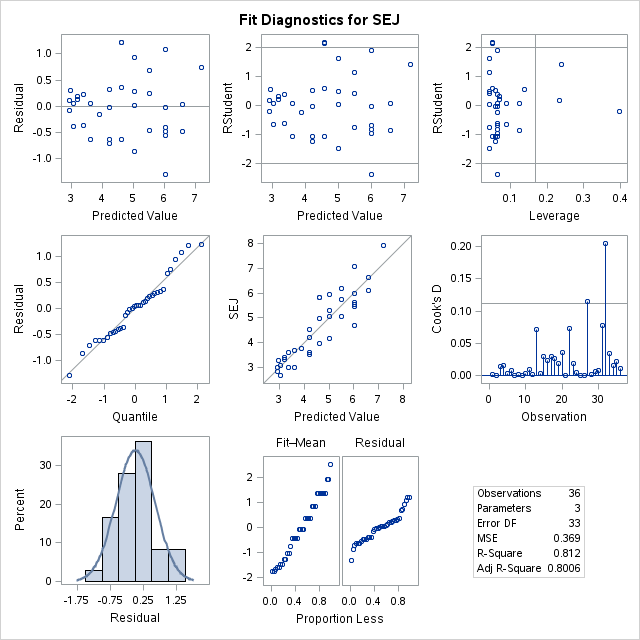
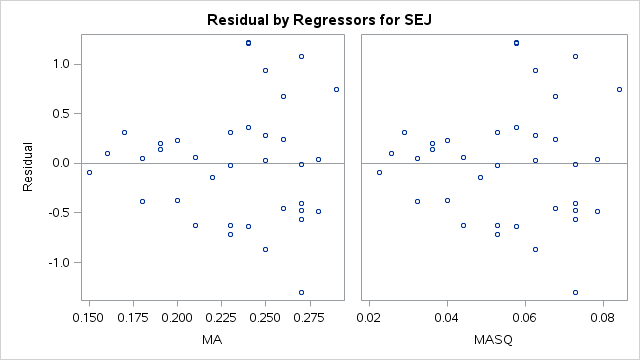

In [14]:
/*
 * ----ASSIGMENT_5---------
 * Author: Jose L Rodriguez
 * Assigment: 5
 * Problem: 3_c
 * Date: October 17th, 2014
 * SAS303 - FALL 2014
 * SAS 9.4 TS Level 1M1 
 * W32_7PRO platform
 */

DATA HAYNAS_DATA;
SET WORK.HAYNAS;
MASQ=MA**2;
PROC REG DATA=HAYNAS_DATA;
MODEL SEJ=MA MASQ;
TITLE "Quadratic Regression - Evolution of the skull structure of bone-cracking hypercarnivores(HAYNAS)";
RUN;
QUIT;

/*
 *	c)	Perform a quadratic regression. State the model (y = ax^2 + bx + c) and r-squared value.
 *			SEJ= 8.60935 - 73.35032*MA + 236.05951*MASQ  
 *		If we compare Residual vs Predicted in the firt and fifth graph, it looks like the values are evenly distributed around the line, 
 *		also there isnt a noticible pattern on graph five. From graph seven(Percent vs Recidual) we can infer that the model follows a 
 *		normal distribution. From graph one and two we can say that the model is Homoscedastic (Variance is constant) as the width/band 
 *		around data remains constant.
 */



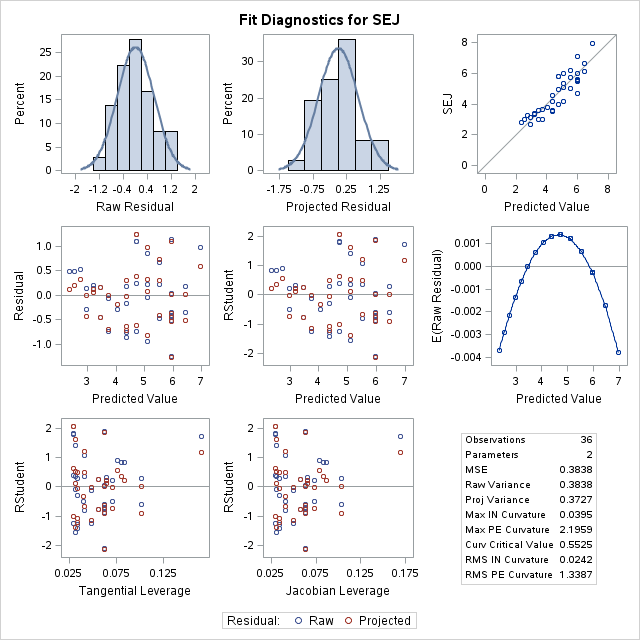
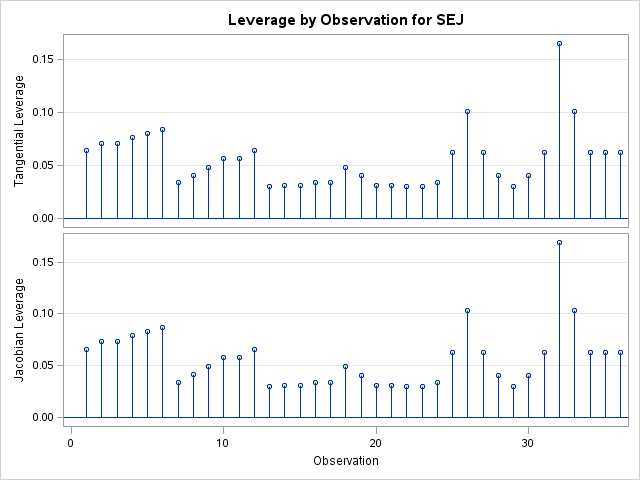
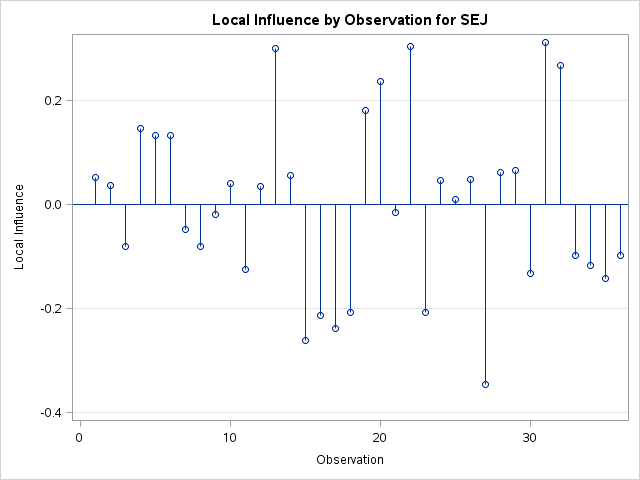

In [15]:
/*
 * ----ASSIGMENT_5---------
 * Author: Jose L Rodriguez
 * Assigment: 5
 * Problem: 3_d_e
 * Date: October 17th, 2014
 * SAS303 - FALL 2014
 * SAS 9.4 TS Level 1M1 
 * W32_7PRO platform
 */

DATA HAYNAS_NONLINEAR;
SET WORK.HAYNAS;
ODS GRAPHICS ON;

PROC Nlin PLOTS=DIAGNOSTICS(STATS=ALL);
PARAMETERS 	a=2 TO 8 BY 2 
			b=0.150 TO 0.275 BY 0.025;
MODEL SEJ = a*exp(b*MA);
RUN;
QUIT;
ODS GRAPHICS OFF;


/*
 *	d)	Perform an exponential regression using Proc Nlin.  
 *		Briefly, analyze the residual assumptions.  
 *		Include the parameters output and 9 panel residual analysis plot. 
 *		
 *		To find the starting values we can do a proc reg and use the parameters from
 *		the graph.
 *
 *		Model:   y = (0.7317) * e**((7.7684)*x)
 *		
 *
 *	e)  Of the quadratic model and the exponential model, which model has the best fit and why?  
 *		The model that that fits the best is the exponential model.
 *
 *
 */



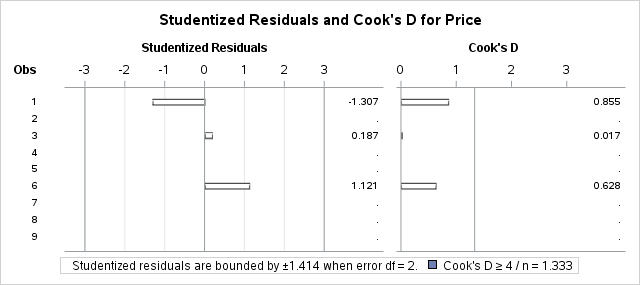
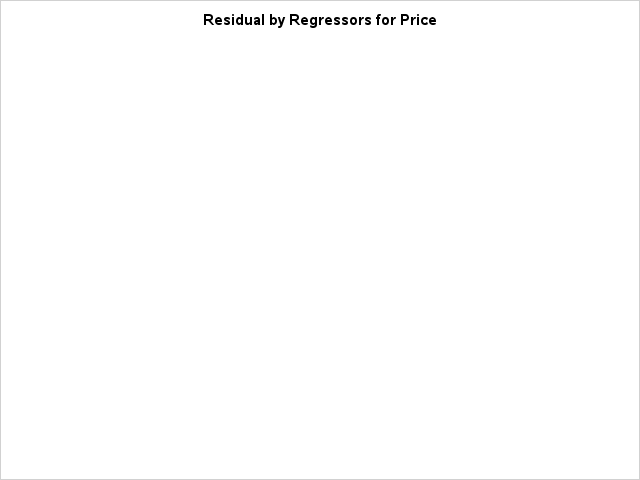

In [19]:
DATA REALSTATE;
INPUT House	Price Living_Area Floors Bedrooms Baths garage;
IF garage="Y" then gar=1;
ELSE gar=0;
datalines;
1 69 6 1 2 1 N
2 118.5	10 1 2 2 Y
3 116.5	10 1 3 2 N
4 125 11 1 3 2 Y
5 129.9	13 1 3 1.5 Y
6 135 13 2 3 2.5 Y
7 139.9	13 1 3 2 Y
8 147.9	17 2 3 2.5 Y
9 160 19 2 3 2 Y
10 169.9 18	1 3	2 Y
11 134.9 13	1 4	2 Y
12 155 18 1	4 2 N
13 169.9 17	2 4	3 N
14 194.5 20	2 4	3 Y
15 209.9 21	2 4	3 Y
;
/*
PROC REG DATA=REALSTATE;
MODEL Price= Living_Area Floors Bedrooms Baths/P R;
PLOT H.*(Living_Area Floors Bedrooms Baths);
RUN;
*/

PROC REG DATA=REALSTATE;
MODEL Price= Living_Area Floors Bedrooms Baths gar/ R P selection = stepwise best = 3;
RUN;
QUIT;



SAS STUDIO EXAMPLE
=======================

PROC REG
=============
https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_reg_sect017.htm  
H.: leverage  
R.: Residual  